In [1]:
# Colab/Notebook setup
!pip -q install shap eli5 python-pptx seaborn sqlalchemy

import numpy as np
import pandas as pd
import sqlite3
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import shap
import eli5
from eli5.sklearn import PermutationImportance
from pptx import Presentation
from pptx.util import Inches, Pt

sns.set(style="whitegrid")
np.random.seed(42)

# Output directories
os.makedirs("outputs", exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 12.7 MB/s eta 0:00:00


In [2]:
# Create SQLite DB
db_path = "telecom_churn.db"
if os.path.exists(db_path):
    os.remove(db_path)

conn = sqlite3.connect(db_path)
cur = conn.cursor()

# Customers master table
cur.execute("""
CREATE TABLE customers (
    customer_id INTEGER PRIMARY KEY,
    plan_type TEXT,
    region TEXT,
    tenure_months INTEGER,
    churn INTEGER
);
""")

# Monthly activity table
cur.execute("""
CREATE TABLE activity (
    activity_id INTEGER PRIMARY KEY AUTOINCREMENT,
    customer_id INTEGER,
    month INTEGER,
    call_duration REAL,       -- minutes per month
    complaints INTEGER,       -- complaints raised per month
    recharge_freq REAL,       -- recharge count per month
    recharge_amount REAL,     -- total recharge amount per month
    FOREIGN KEY(customer_id) REFERENCES customers(customer_id)
);
""")

# Synthetic data generation
n_customers = 3000
regions = ["North", "South", "East", "West", "Central"]
plans = ["Prepaid-Basic", "Prepaid-Plus", "Postpaid-Standard", "Postpaid-Premium"]

# Generate customers
customers = []
for cid in range(1, n_customers + 1):
    region = np.random.choice(regions, p=[0.22, 0.26, 0.18, 0.20, 0.14])
    plan = np.random.choice(plans, p=[0.35, 0.30, 0.25, 0.10])
    tenure = np.random.randint(1, 48)

    # Baseline churn probability influenced by tenure, complaints expectation, and plan
    plan_risk = {
        "Prepaid-Basic": 0.20,
        "Prepaid-Plus": 0.14,
        "Postpaid-Standard": 0.12,
        "Postpaid-Premium": 0.08,
    }[plan]
    churn_prob = plan_risk + (0.15 if tenure < 6 else 0) + np.random.normal(0, 0.03)
    churn = int(np.clip(churn_prob, 0, 1) > 0.22)

    customers.append((cid, plan, region, tenure, churn))

cur.executemany("INSERT INTO customers (customer_id, plan_type, region, tenure_months, churn) VALUES (?, ?, ?, ?, ?)", customers)

# Generate monthly activity (6–12 months per customer)
activities = []
for cid, plan, region, tenure, churn in customers:
    months = np.random.randint(6, 13)
    for m in range(1, months + 1):
        # Activity varies by plan and churn status
        base_call = {
            "Prepaid-Basic": 200, "Prepaid-Plus": 260,
            "Postpaid-Standard": 300, "Postpaid-Premium": 360
        }[plan]
        call_duration = np.random.normal(base_call, 40)
        call_duration = max(30, call_duration)

        complaints = np.random.poisson(0.25 if plan.startswith("Postpaid") else 0.35)
        if churn:
            complaints += np.random.binomial(1, 0.25)

        base_recharge_freq = 4 if "Prepaid" in plan else 1
        recharge_freq = max(0, np.random.normal(base_recharge_freq, 0.7))
        if churn:
            recharge_freq = max(0, recharge_freq - np.random.uniform(0, 0.8))

        base_amount = {
            "Prepaid-Basic": 300, "Prepaid-Plus": 450,
            "Postpaid-Standard": 700, "Postpaid-Premium": 1200
        }[plan]
        recharge_amount = np.random.normal(base_amount, base_amount * 0.2)
        if churn:
            recharge_amount *= np.random.uniform(0.6, 0.95)
        recharge_amount = max(50, recharge_amount)

        activities.append((cid, m, float(call_duration), int(complaints), float(recharge_freq), float(recharge_amount)))

cur.executemany("""
INSERT INTO activity (customer_id, month, call_duration, complaints, recharge_freq, recharge_amount)
VALUES (?, ?, ?, ?, ?, ?)
""", activities)

conn.commit()
print("SQLite database created with customers and monthly activity.")

SQLite database created with customers and monthly activity.


In [3]:
# Aggregate monthly activity into customer-level features using SQL
query = """
SELECT
  c.customer_id,
  c.plan_type,
  c.region,
  c.tenure_months,
  c.churn,
  COUNT(a.month) AS months_observed,
  AVG(a.call_duration) AS avg_call_duration,
  SUM(a.complaints) AS total_complaints,
  AVG(a.recharge_freq) AS avg_recharge_freq,
  AVG(a.recharge_amount) AS avg_recharge_amount,
  SUM(CASE WHEN a.recharge_amount < 250 THEN 1 ELSE 0 END) * 1.0 / COUNT(a.month) AS low_value_recharge_ratio
FROM customers c
JOIN activity a ON a.customer_id = c.customer_id
GROUP BY c.customer_id, c.plan_type, c.region, c.tenure_months, c.churn
"""

df = pd.read_sql_query(query, conn)

# Derived features
df["complaints_per_month"] = df["total_complaints"] / df["months_observed"]
df["recharge_consistency"] = 1.0 / (1.0 + df["avg_recharge_freq"].ravel())
df["usage_intensity"] = df["avg_call_duration"] / (df["avg_recharge_amount"] + 1)

df.head()

/tmp/ipython-input-1598360900.py:24: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  df["recharge_consistency"] = 1.0 / (1.0 + df["avg_recharge_freq"].ravel())


,customer_id,plan_type,region,tenure_months,churn,months_observed,avg_call_duration,total_complaints,avg_recharge_freq,avg_recharge_amount,low_value_recharge_ratio,complaints_per_month,recharge_consistency,usage_intensity
0,1,Postpaid-Premium,South,43,0,10,361.988589,3,1.043906,1246.767671,0.000000,0.300000,0.489259,0.290109
1,2,Prepaid-Basic,South,11,1,9,202.042459,6,3.591454,241.056340,0.666667,0.666667,0.217796,0.834692
2,3,Prepaid-Plus,Central,24,0,10,264.517542,4,3.639846,473.102466,0.000000,0.400000,0.215524,0.557933
3,4,Postpaid-Premium,West,2,1,12,337.598420,7,0.587507,891.259136,0.000000,0.583333,0.629918,0.378364
4,5,Prepaid-Basic,North,12,0,9,213.232510,3,3.947322,281.198177,0.222222,0.333333,0.202130,0.755613


In [4]:
# Features and target
target = "churn"
categorical = ["plan_type", "region"]
numeric = [
    "tenure_months", "months_observed", "avg_call_duration", "total_complaints",
    "avg_recharge_freq", "avg_recharge_amount", "low_value_recharge_ratio",
    "complaints_per_month", "recharge_consistency", "usage_intensity"
]

X = df[categorical + numeric]
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Preprocessing: OneHot for categoricals, StandardScaler for numerics
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric)
    ]
)

In [5]:
# Logistic Regression pipeline
logreg_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", C=1.0, solver="lbfgs"))
])

# Random Forest pipeline
rf_clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=2, random_state=42,
        class_weight="balanced_subsample", n_jobs=-1
    ))
])

# Train
logreg_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# Predict probabilities for segmentation and ROC
y_pred_lr = logreg_clf.predict(X_test)
y_proba_lr = logreg_clf.predict_proba(X_test)[:, 1]

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

LogisticRegression — Accuracy: 0.968, Precision: 0.878, Recall: 0.956, F1: 0.915, ROC-AUC: 0.995
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       614
           1       0.88      0.96      0.92       136

    accuracy                           0.97       750
   macro avg       0.93      0.96      0.95       750
weighted avg       0.97      0.97      0.97       750


--------------------------------------------------



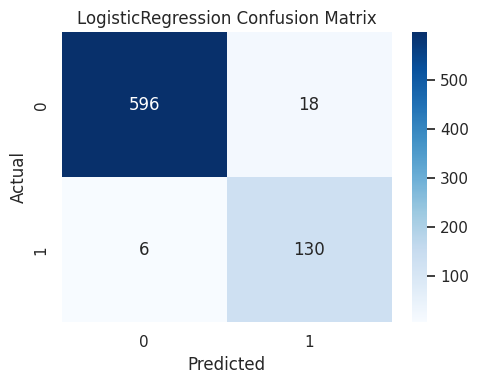


--------------------------------------------------



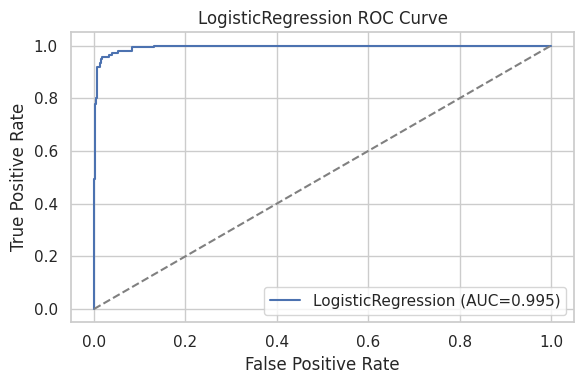


--------------------------------------------------

RandomForest — Accuracy: 0.989, Precision: 0.957, Recall: 0.985, F1: 0.971, ROC-AUC: 0.999
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       614
           1       0.96      0.99      0.97       136

    accuracy                           0.99       750
   macro avg       0.98      0.99      0.98       750
weighted avg       0.99      0.99      0.99       750


--------------------------------------------------



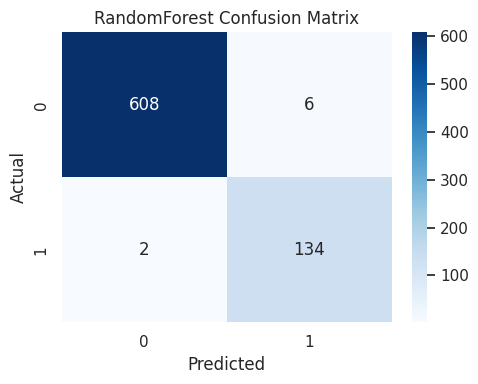


--------------------------------------------------



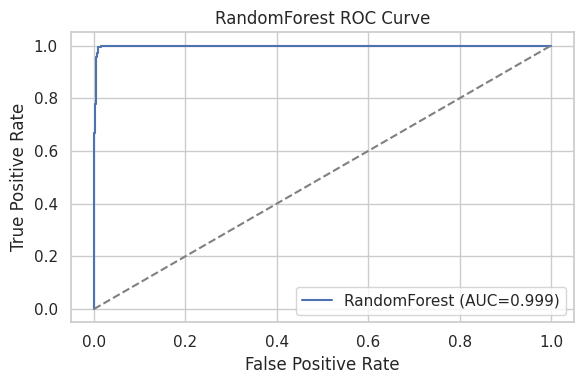


--------------------------------------------------



In [7]:
def evaluate_and_plot(y_true, y_pred, y_proba, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    print(f"{model_name} — Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, ROC-AUC: {auc:.3f}")
    print(classification_report(y_true, y_pred))
    print("\n" + "-"*50 + "\n")
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"outputs/{model_name}_confusion_matrix.png", dpi=150)
    plt.show()
    print("\n" + "-"*50 + "\n")
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})")
    plt.plot([0,1], [0,1], "--", color="grey")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"outputs/{model_name}_roc.png", dpi=150)
    plt.show()
    print("\n" + "-"*50 + "\n")

evaluate_and_plot(y_test, y_pred_lr, y_proba_lr, "LogisticRegression")
evaluate_and_plot(y_test, y_pred_rf, y_proba_rf, "RandomForest")

   segment  count
0  Neutral    442
1    Loyal    167
2  At Risk    141


/tmp/ipython-input-4237312169.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seg_counts, x="segment", y="count", palette="viridis")


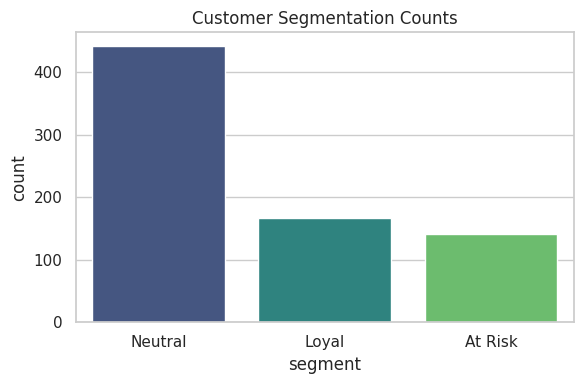

Saved segmentation table to outputs/customer_segments_test.csv


In [10]:
# Choose model for deployment/segmentation: RandomForest (usually stronger)
df_test = X_test.copy()
df_test["churn"] = y_test.values
df_test["churn_prob"] = y_proba_rf

# Add raw features for thresholds
df_test["avg_call_duration"] = X_test["avg_call_duration"].values
df_test["avg_recharge_freq"] = X_test["avg_recharge_freq"].values
df_test["complaints_per_month"] = X_test["complaints_per_month"].values

# Segmentation rules (adjust as needed)
def segment_row(row):
    if row["churn_prob"] >= 0.60 or (row["complaints_per_month"] > 0.6 and row["avg_recharge_freq"] < 2.0):
        return "At Risk"
    if row["churn_prob"] <= 0.30 and row["avg_recharge_freq"] >= 2.0 and row["avg_call_duration"] >= 250:
        return "Loyal"
    if row["avg_call_duration"] < 180 and row["avg_recharge_freq"] < 1.2:
        return "Dormant"
    return "Neutral"

df_test["segment"] = df_test.apply(segment_row, axis=1)

seg_counts = df_test["segment"].value_counts().rename_axis("segment").reset_index(name="count")
print(seg_counts)

plt.figure(figsize=(6,4))
sns.barplot(data=seg_counts, x="segment", y="count", palette="viridis")
plt.title("Customer Segmentation Counts")
plt.tight_layout()
plt.savefig("outputs/segmentation_counts.png", dpi=150)
plt.show()

# Save segmented table
df_test.to_csv("outputs/customer_segments_test.csv", index=False)
print("Saved segmentation table to outputs/customer_segments_test.csv")

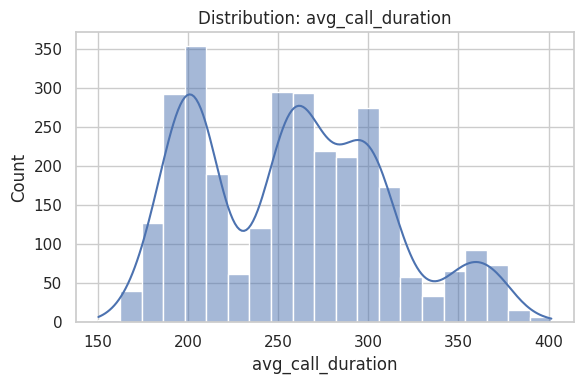

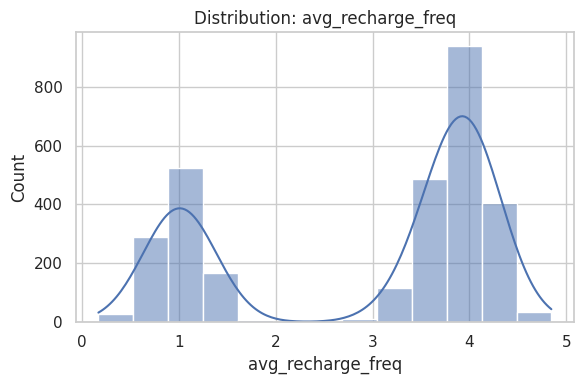

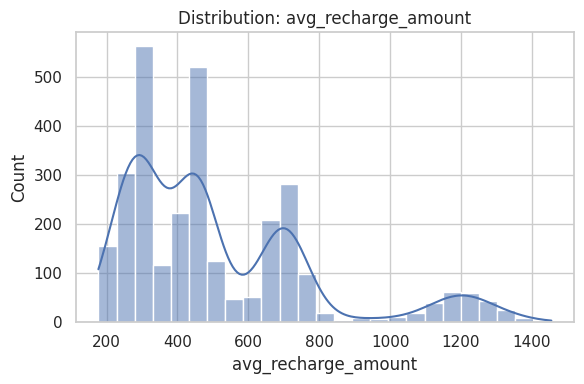

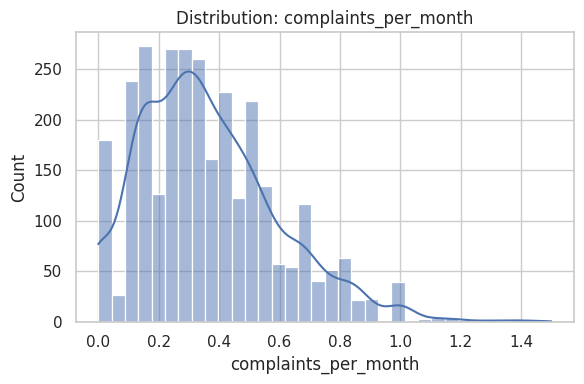

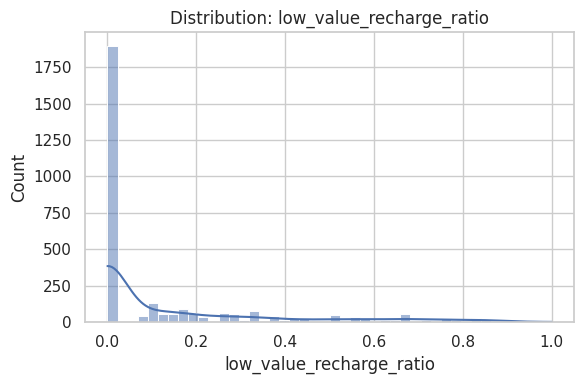

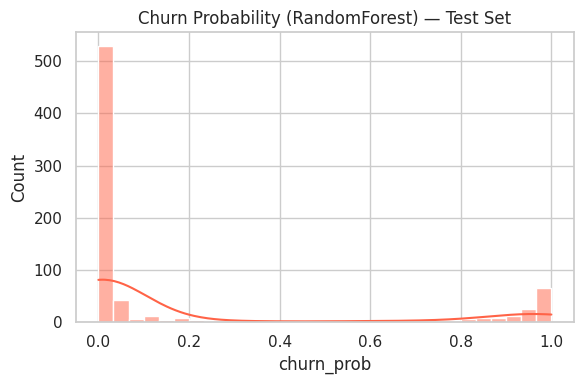

In [11]:
# Feature distributions
features_to_plot = ["avg_call_duration", "avg_recharge_freq", "avg_recharge_amount", "complaints_per_month", "low_value_recharge_ratio"]
for f in features_to_plot:
    plt.figure(figsize=(6,4))
    sns.histplot(df[f], kde=True)
    plt.title(f"Distribution: {f}")
    plt.tight_layout()
    plt.savefig(f"outputs/dist_{f}.png", dpi=150)
    plt.show()

# Churn probability distribution
plt.figure(figsize=(6,4))
sns.histplot(df_test["churn_prob"], bins=30, kde=True, color="tomato")
plt.title("Churn Probability (RandomForest) — Test Set")
plt.tight_layout()
plt.savefig("outputs/churn_probability_rf.png", dpi=150)
plt.show()

In [12]:
prs = Presentation()

# Title slide
slide = prs.slides.add_slide(prs.slide_layouts[0])
title = slide.shapes.title
subtitle = slide.placeholders[1]
title.text = "Telecom Customer Churn Analysis"
subtitle.text = "End-to-end: SQL, ML, Explainability, Segmentation, Reporting"

# Metrics slide
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Model Performance Summary"
tf = slide.placeholders[1].text_frame
tf.clear()
tf.paragraphs[0].text = "Two models trained:"
p = tf.add_paragraph(); p.text = "• Logistic Regression with class_weight=balanced"
p = tf.add_paragraph(); p.text = "• Random Forest with class_weight=balanced_subsample"
p = tf.add_paragraph(); p.text = "Metrics saved: Confusion Matrix + ROC for both"

# Insert images: confusion matrices & ROC
for img in ["outputs/LogisticRegression_confusion_matrix.png",
            "outputs/LogisticRegression_roc.png",
            "outputs/RandomForest_confusion_matrix.png",
            "outputs/RandomForest_roc.png"]:
    try:
        slide = prs.slides.add_slide(prs.slide_layouts[5])
        slide.shapes.title.text = os.path.basename(img).replace("_", " ").replace(".png", "")
        left = Inches(0.5)
        top = Inches(1.5)
        slide.shapes.add_picture(img, left, top, width=Inches(9))
    except Exception as e:
        pass

# Explainability slide
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Explainability: Key Drivers of Churn"
tf = slide.placeholders[1].text_frame
tf.clear()
tf.paragraphs[0].text = "Drivers observed across models:"
p = tf.add_paragraph(); p.text = "• High complaints per month"
p = tf.add_paragraph(); p.text = "• Low recharge frequency and low recharge amount"
p = tf.add_paragraph(); p.text = "• Short tenure and low usage consistency"
p = tf.add_paragraph(); p.text = "Refer: outputs/eli5_lr.html and outputs/shap_summary_rf.png"

# Segmentation slide
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Customer Segments"
tf = slide.placeholders[1].text_frame
tf.clear()
tf.paragraphs[0].text = "Segments:"
p = tf.add_paragraph(); p.text = "• At Risk: churn_prob ≥ 0.60 or high complaints + low recharge"
p = tf.add_paragraph(); p.text = "• Loyal: churn_prob ≤ 0.30 + consistent usage"
p = tf.add_paragraph(); p.text = "• Dormant: low activity and low recharge"
p = tf.add_paragraph(); p.text = "• Neutral: others"

# Insert segmentation chart
try:
    slide = prs.slides.add_slide(prs.slide_layouts[5])
    slide.shapes.title.text = "Segmentation Counts"
    slide.shapes.add_picture("outputs/segmentation_counts.png", Inches(0.5), Inches(1.5), width=Inches(9))
except:
    pass

# Recommendations slide
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Final Recommendations"
tf = slide.placeholders[1].text_frame
tf.clear()
tf.paragraphs[0].text = "Retention strategies:"
p = tf.add_paragraph(); p.text = "• Proactive complaint resolution and fast SLA for high-risk customers"
p = tf.add_paragraph(); p.text = "• Personalized recharge bundles for low-frequency and low-amount segments"
p = tf.add_paragraph(); p.text = "• Loyalty rewards for long-tenure and high-usage customers"
p = tf.add_paragraph(); p.text = "• Win-back campaigns for dormant users with targeted incentives"
p = tf.add_paragraph(); p.text = "• Monitor churn probability weekly and prioritize outreach"

# Save PPTX
pptx_path = "outputs/Telecom_Churn_Report.pptx"
prs.save(pptx_path)
print(f"PowerPoint saved to {pptx_path}")

PowerPoint saved to outputs/Telecom_Churn_Report.pptx


In [13]:
# Quick text-based feature importance from Logistic Regression coefficients (approximate)
# Fit a plain logreg on transformed features to get coefficients
prep = logreg_clf.named_steps["prep"]
model_lr = logreg_clf.named_steps["model"]
coef = model_lr.coef_.ravel()

feature_names = list(prep.named_transformers_["cat"].get_feature_names_out(categorical)) + numeric
imp_df = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef", ascending=False)
imp_df.head(10)

,feature,coef
18,usage_intensity,4.049739
0,plan_type_Postpaid-Premium,3.524376
3,plan_type_Prepaid-Plus,2.203109
17,recharge_consistency,1.605065
15,low_value_recharge_ratio,1.093129
12,total_complaints,1.064971
8,region_West,0.358794
4,region_Central,0.195622
16,complaints_per_month,-0.092899
6,region_North,-0.167981
